<a href="https://colab.research.google.com/github/EllenBonafin/machine-learning-clusterr/blob/main/ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANDO

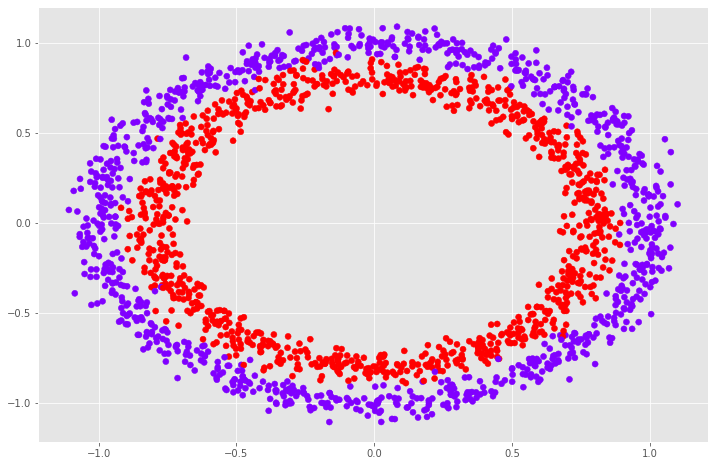

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import style, cm
import matplotlib.tri as mtri
import time
from sklearn.metrics import accuracy_score, silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

style.use('ggplot')
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

#importando a base de dados 
db= pd.read_csv('/content/Base8.csv')
#data = make_blobs(n_samples=200,n_features=2,centers=4,cluster_std=1,random_state=23)
plt.figure(figsize=(12,8))
x= []
x.append(db.iloc[:,0:2].values)
x.append(db.iloc[:,2:3].values)
x
plt.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")


In [ ]:
X= np.array(db.values[:, :2])
label= np.array(db.values[:, 2])

COESAO

In [ ]:
from sklearn.metrics import accuracy_score, silhouette_score, pairwise_distances
def coesao_value(X, labels):
    each_label= np.unique(labels)
    valu= 0
    for lab in each_label:
        if lab!=-1:
            indexes= np.where(labels == lab)
            indexes= indexes[0]
            subX= np.take(X, indexes, axis=0)
            valu+= np.sum(pairwise_distances(subX, metric='sqeuclidean', n_jobs=-1))
    return np.sqrt(valu)

SEPARAÇÃO

In [ ]:
def separabilidade_value(X, labels):
    each_label= np.unique(labels)
    value= 0 #iniciado em zero

    for lab in each_label:
        if lab!=-1:
            index_X= np.where(labels == lab)
            index_X= index_X[0]

            index_Y= np.where(np.logical_and(labels != lab, labels!=-1))
            index_Y= index_Y[0]
            
            subX= np.take(X, index_X, axis=0)
            subY= np.take(X, index_Y, axis=0)

            # distancia euclidiana entre os pontos
            value+= np.sum(pairwise_distances(subX, subY, metric='sqeuclidean', n_jobs=-1))
    return np.sqrt(value)

ENTROPIA

In [ ]:
def entropia_value(X, label_class, label_dataset):
    cluster_labels= np.unique(label_dataset)
    entropia_valueE= 0 #iniciada em zero
    for label in cluster_labels:

        entropia_c= 0
        
        cluster_index= np.where(label_dataset == label)
        cluster_index= cluster_index[0]
        cluster_classes= np.take(label_class, cluster_index)

        classes, points_c= np.unique(cluster_classes, return_counts=True)
        cluster_sum= np.sum(points_c)
        if classes[0]==-1:
            points_c= points_c[1:]
        points_c= points_c / cluster_sum

        for p in points_c:
            entropia_c+= p * np.log2(p)
            entropia_valueE-= entropia_c

            entropia_valueE/= len(cluster_labels)
    return entropia_valueE

KMEANS


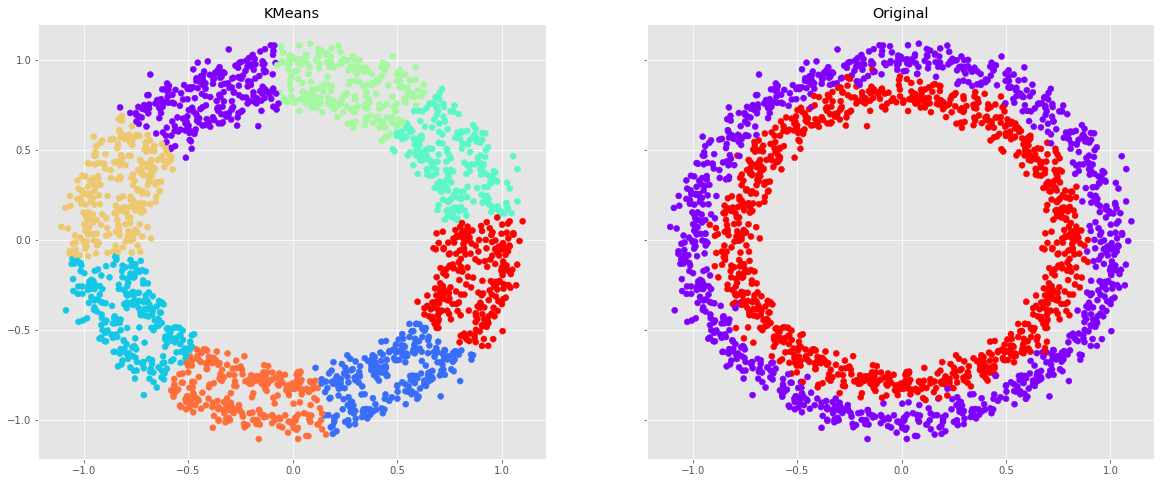

In [ ]:
from sklearn.cluster import KMeans
kmeans= KMeans(n_clusters=8)
# kmeans= KMeans(n_clusters=6)
# kmeans= KMeans(n_clusters=9)
# kmeans= KMeans(n_clusters=27)
kmeans.fit(x[0])
kmeans.cluster_centers_
kmeans.labels_

f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,8))
ax1.set_title("KMeans")
ax1.scatter(x[0][:,0],x[0][:,1],c=kmeans.labels_,cmap="rainbow")
ax2.set_title("Original")
ax2.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")

In [ ]:
kmeans_parameters = {
    "n_clusters": [i for i in range(2, 9)],
    "max_iter": [j for j in range(1, 11)]
}

cluster_size= np.shape(kmeans_parameters['n_clusters'])[0]
iter_size= np.shape(kmeans_parameters['max_iter'])[0]

kmeans_value_coesao= np.zeros((cluster_size, iter_size))
kmeans_value_separabilidade= np.zeros((cluster_size, iter_size))
kmeans_value_entropia= np.zeros((cluster_size, iter_size))
kmeans_value_silhueta= np.zeros((cluster_size, iter_size))


i= 0
j= 0
for n_cluster in kmeans_parameters["n_clusters"]:
    j= 0
    for iteration in kmeans_parameters["max_iter"]:
        kmc= KMeans(n_clusters=n_cluster, max_iter=iteration).fit(X)
        kmc_labels= kmc.labels_
        coesao= coesao_value (X, kmc_labels)
        separabilidade= separabilidade_value(X, kmc_labels)
        entropia= entropia_value(X, kmc_labels, label)
        silhueta= silhouette_score(X, kmc_labels, metric='euclidean')

        kmeans_value_coesao[i, j]= coesao
        kmeans_value_separabilidade[i, j]= separabilidade
        kmeans_value_entropia[i, j]= entropia
        kmeans_value_silhueta[i, j]= silhueta

        j += 1
    i += 1

        

In [ ]:
template_shape= np.shape(kmeans_value_coesao)

maxScore_coesao_kmeans= np.min(kmeans_value_coesao)
minScore_separabilidade_kmeans= np.max(kmeans_value_separabilidade)
minScore_entropia_kmeans= np.min(kmeans_value_entropia )
maxScore_silhueta_kmeans = np.max(kmeans_value_silhueta)

index_coesao= np.unravel_index(np.argmin(kmeans_value_coesao), template_shape)
index_separabilidade= np.unravel_index(np.argmax(kmeans_value_separabilidade), template_shape)
index_entropia= np.unravel_index(np.argmin(kmeans_value_entropia ), template_shape)
index_silhueta = np.unravel_index(np.argmax(kmeans_value_silhueta), template_shape)
#Melhores parametros
bestIter_coesao= kmeans_parameters['max_iter'][index_coesao[1]]
bestN_coesao= kmeans_parameters['n_clusters'][index_coesao[0]]

bestIter_separabilidade= kmeans_parameters['max_iter'][index_separabilidade[1]]
bestN_separabilidade= kmeans_parameters['n_clusters'][index_separabilidade[0]]

bestIter_entropia= kmeans_parameters['max_iter'][index_entropia[1]]
bestN_entropia= kmeans_parameters['n_clusters'][index_entropia[0]]

bestIter_silhueta= kmeans_parameters['max_iter'][index_silhueta[1]]
bestN_silhueta= kmeans_parameters['n_clusters'][index_silhueta[0]]

#mostra melhores valores obtidos 
print("KMEANS")
print(f"\nCoesao\n Melhor pontuação ->{maxScore_coesao_kmeans} \n Melhores com:\n contendo {bestIter_coesao} iterações e {bestN_coesao} centroides")
print(f"\nSeparabilidade:\n Melhor pontuação ->{minScore_separabilidade_kmeans}\n Melhores com:\n contendo {bestIter_separabilidade} iterações e {bestN_separabilidade} centroides.")
print(f"\nEntropia:\n Melhor pontuação ->{minScore_entropia_kmeans}\n Melhores com:\n contendo {bestIter_entropia} iterações e {bestN_entropia} centroides.")
print(f"\nSilhueta:\n Melhor pontuação ->{maxScore_silhueta_kmeans} \n Melhores com:\n contendo {bestIter_silhueta} iterações e {bestN_silhueta} centroides.")

KMEANS

Coesao
 Melhor pontuação ->228.93997479850256 
 Melhores com:
 contendo 8 iterações e 8 centroides

Separabilidade:
 Melhor pontuação -> 2558.9034571860384
 Melhores com:
 contendo 8 iterações e 8 centroides.

Entropia:
 Melhor pontuação ->0.7801314290443686
 Melhores com:
 contendo 2 iterações e 2 centroides.

Silhueta:
 Melhor pontuação -> (0.4678399227824325) 
 Melhores com:
 contendo 3 iterações e 4 centroides.


DBSACN

[0 0 0 ... 0 0 0]


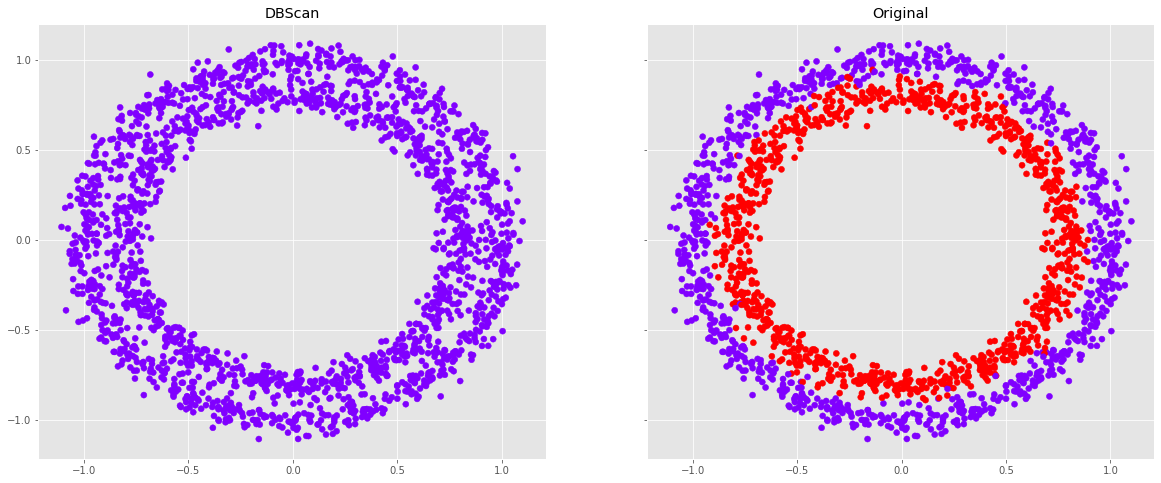

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5).fit(x[0])

f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,8))
ax1.set_title("DBScan")
ax1.scatter(x[0][:,0],x[0][:,1],c=dbscan.labels_,cmap="rainbow")
ax2.set_title("Original")
ax2.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")
print(dbscan.labels_)

In [ ]:
bd_coordinate_x= distance.cdist(X, [[.0, 1.0]]).argmin()
bd_coordinate_y= distance.cdist(X, [[1.0, -0.5]]).argmin()

In [ ]:
#Variaçao de parametros
dbsacn_p= {
    "eps": [i/100 for i in range(1, 16)],
    "min_samples": [i for i in range(3, 14)]
}
validated_params = []

for epsx in dbsacn_p["eps"]:
    j= 0
    for min_sample in dbsacn_p["min_samples"]:
        dbs= DBSCAN(eps=epsx, min_samples=min_sample).fit(X)
        dbs_labels= dbs.labels_

        if(dbs_labels[bd_coordinate_x] != dbs_labels[bd_coordinate_y] and len(np.unique(dbs_labels)) <= 8):
            validated_params.append([epsx, min_sample])

In [ ]:
validated_params= np.array(validated_params)

unique_eps= np.unique(validated_params[:, 0]) 
unique_samples= np.unique(validated_params[:, 1]) 

matrix_size= ((np.shape(unique_eps)[0], np.shape(unique_samples)[0]))

dbsacn_value_coesao= np.zeros(matrix_size)
dbscan_value_separabilidade= np.zeros(matrix_size)
dbscan_value_entropia= np.zeros(matrix_size)
dbscan_value_silhueta= np.zeros(matrix_size)

i= 0
j= 0
for eps in unique_eps:
    j = 0
    for sample in unique_samples:
        if [eps, sample] in validated_params.tolist():
          dbs= DBSCAN(eps=eps, min_samples=sample, n_jobs=-1).fit(X)
          dbs_labels= dbs.labels_ 

          coesao= coesao_value(X, dbs_labels)
          entropia= entropia_value(X, dbs_labels, label)
          entropia= entropia_value(X, dbs_labels, label)
          silhouette  = silhouette_score(X, dbs_labels, metric='euclidean')

          dbsacn_value_coesao[i, j]= coesao
          dbscan_value_separabilidade[i, j]=separabilidade
          dbscan_value_entropia[i, j]= entropia
          dbscan_value_silhueta[i, j]= silhouette
        else: 
          dbsacn_value_coesao[i, j]= float("inf")
          dbscan_value_separabilidade[i, j]= float("inf")
          dbscan_value_entropia[i, j]= float("inf")
          dbscan_value_silhueta[i, j]= float("inf")
          
        j+=1
    i+=1

dbsacn_value_coesao_= np.where(dbsacn_value_coesao == float("inf"), np.min(dbsacn_value_coesao)*.99, dbsacn_value_coesao)
dbscan_value_separabilidade_= np.where(dbscan_value_separabilidade == float("inf"), np.min(dbscan_value_separabilidade)*.99, dbscan_value_separabilidade)
dbscan_value_entropia_= np.where(dbscan_value_entropia == float("inf"), np.min(dbscan_value_entropia)*.99, dbscan_value_entropia)
dbscan_value_silhueta = np.where(dbscan_value_silhueta == float("inf"), np.min(dbscan_value_silhueta)*.99, dbscan_value_silhueta)


dbscan_value_separabilidade= np.where(dbsacn_value_coesao == float("inf"), 0, dbsacn_value_coesao)
dbscan_value_silhueta = np.where(dbscan_value_silhueta == float("inf"), 0, dbscan_value_silhueta)
template_shape= np.shape(dbsacn_value_coesao)

maxScore_coesao_dbs= np.min(dbsacn_value_coesao)
minScore_separabilidade_dbs= np.max(dbscan_value_separabilidade)
minScore_entropia_dbs= np.min(dbscan_value_entropia)
maxScore_silhueta_dbs = np.max(dbscan_value_silhueta)

index_coesao= np.unravel_index(np.argmin(dbsacn_value_coesao), template_shape)
index_separabilidade= np.unravel_index(np.argmax(dbscan_value_separabilidade), template_shape)
index_entropia= np.unravel_index(np.argmin(dbscan_value_entropia), template_shape)
index_silhueta= np.unravel_index(np.argmax(dbscan_value_silhueta), template_shape)

bestEps_coesao= unique_eps[index_coesao[0]]
bestMinSamples_coesao= unique_samples[index_coesao[1]]

bestEps_separabilidade= unique_eps[index_separabilidade[0]]
bestMinSamples_separabilidade= unique_samples[index_separabilidade[1]]

bestEps_entropia= unique_eps[index_entropia[0]]
bestMinSamples_entropia= unique_samples[index_entropia[1]]

bestEps_silhueta= unique_eps[index_silhueta[0]]
bestEps_silhueta= unique_samples[index_silhueta[1]]

#mostra melhores valores obtidos 
print("DBSCAN")
print(f"\nCoesao\n Melhor pontuação ->{maxScore_coesao_dbs}\n Melhores com:\n contendo{bestEps_coesao} tamanho de raio e {bestMinSamples_coesao} número mínimo de pontos.\n")
print(f"\nSeparabilidade:\n Melhor pontuação ->{minScore_separabilidade_dbs}\n Melhores com:\n contendo{bestEps_separabilidade} tamanho de raio e {bestMinSamples_separabilidade} número mínimo de pontos.\n")
print(f"\nEntropia:\n Melhor pontuação ->{minScore_entropia_dbs}\n Melhores com:\n contendo {bestEps_entropia} tamanho de raio e {bestMinSamples_entropia} número mínimo de pontos.\n")
print(f"\nSilhueta:\n Melhor pontuação ->{maxScore_silhueta_dbs}\n Melhores com:\n contendo {bestEps_silhueta} tamanho de raio e {bestEps_silhueta} número mínimo de pontos.\n")

DBSCAN

Coesao
 Melhor pontuação ->2233.832180765962
 Melhores com:
 contendo0.06 tamanho de raio e 9.0 número mínimo de pontos.


Separabilidade:
 Melhor pontuação ->2549.243729786469
 Melhores com:
 contendo0.07 tamanho de raio e 6.0 número mínimo de pontos.


Entropia:
 Melhor pontuação ->0.005386761530599308
 Melhores com:
 contendo 0.07 tamanho de raio e 6.0 número mínimo de pontos.


Silhueta:
 Melhor pontuação ->0.09051646832079012
 Melhores com:
 contendo 7.0 tamanho de raio e 7.0 número mínimo de pontos



AGNES


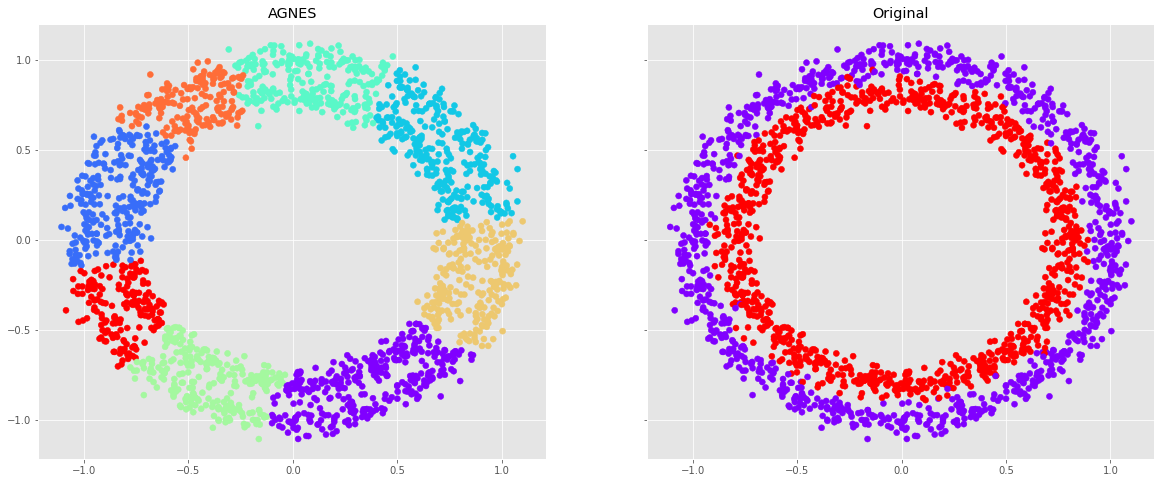

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agnes = AgglomerativeClustering(n_clusters=8,linkage="ward").fit(x[0])
import scipy as sp 
sp.stats.entropy(agnes.labels_)

f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,8))
ax1.set_title("AGNES")
ax1.scatter(x[0][:,0],x[0][:,1],c=agnes.labels_,cmap="rainbow")
ax2.set_title("Original")
ax2.scatter(x[0][:,0],x[0][:,1],c=x[1],cmap="rainbow")



In [ ]:
linkage_dict = {
    0: "ward",
    1: "complete",
    2: "single"
}

agc_parameters = {
    'n_clusters': [i for i in range(2, 9)],
    'linkage': [0, 1, 2]
}

cluster_size= np.shape(agc_parameters['n_clusters'])[0]
linkage_size= np.shape(agc_parameters['linkage'])[0]

agnes_value_coesao= np.zeros((cluster_size, linkage_size))
agnes_value_separabilidade= np.zeros((cluster_size, linkage_size))
agnes_value_entropia= np.zeros((cluster_size, linkage_size))
agnes_value_silhueta= np.zeros((cluster_size, linkage_size))
#agnes_value_silhueta
i= 0
j= 0
for n_cluster in agc_parameters['n_clusters']:
    j= 0
    for linkage in agc_parameters['linkage']:
        agc= AgglomerativeClustering(linkage=linkage_dict[linkage], n_clusters=n_cluster).fit(X)
        agc_labels= agc.labels_ 

        coesao= coesao_value(X, agc_labels)            
        separabilidade= separabilidade_value(X, agc_labels)   
        entropia= entropia_value(X, agc_labels, label)
        silhueta  = silhouette_score(X, agc_labels, metric='euclidean')

        agnes_value_coesao[i, j]= coesao
        agnes_value_separabilidade[i, j]= separabilidade
        agnes_value_entropia[i, j]= entropia
        agnes_value_silhueta[i, j]= silhueta
        j += 1
    i += 1

template_shape= np.shape(agnes_value_coesao)

maxScore_coesao_ag= np.min(agnes_value_coesao)
minScore_separabilidade_ag= np.max(agnes_value_separabilidade)
minScore_entropia_ag= np.min(agnes_value_entropia)
maxScore_silhueta_ag= np.max(agnes_value_silhueta)

index_coesao= np.unravel_index(np.argmin(agnes_value_coesao), template_shape)
index_separabilidade= np.unravel_index(np.argmax(agnes_value_separabilidade), template_shape)
index_entropia= np.unravel_index(np.argmin(agnes_value_entropia), template_shape)
index_silhueta= np.unravel_index(np.argmax(agnes_value_silhueta), template_shape)

bestNAg_coesao= agc_parameters['n_clusters'][index_coesao[0]]
bestLinkage_coesao= agc_parameters['linkage'][index_coesao[1]]

bestNAg_separabilidade= agc_parameters['n_clusters'][index_separabilidade[0]]
bestLinkage_separabilidade= agc_parameters['linkage'][index_separabilidade[1]]

bestNAg_entropia= agc_parameters['n_clusters'][index_entropia[0]]
bestLinkage_entropia= agc_parameters['linkage'][index_entropia[1]]

bestNAg_silhueta= agc_parameters['n_clusters'][index_silhueta[0]]
bestLinkage_silhueta= agc_parameters['linkage'][index_silhueta[1]]

#mostra melhores valores obtidos 
print("AGNES")
print(f"\nCoesao\n Melhor pontuação ->{maxScore_coesao_ag}\n Melhores com:\n contendo {bestNAg_coesao} clusters {linkage_dict[bestLinkage_coesao]}\n")
print(f"\nSeparabilidade:\n Melhor pontuação ->{minScore_separabilidade_ag}\n Melhores com:\n contendo {bestNAg_separabilidade} clusters {linkage_dict[bestLinkage_separabilidade]}\n")
print(f"\nEntropia:\n Melhor pontuação ->{minScore_entropia_ag}\n Melhores com:\n contendo {bestNAg_entropia} clusters {linkage_dict[bestLinkage_entropia]}\n")
print(f"\nSilhueta:\n Melhor pontuação ->{maxScore_silhueta_ag}\n Melhores com:\n contendo {bestNAg_silhueta} número de clusters e {linkage_dict[bestLinkage_silhueta]} medida de similaridade.\n")


AGNES

Coesao
 Melhor pontuação ->250.60997818838118
 Melhores com:
 contendo 8 clusters ward


Separabilidade:
 Melhor pontuação ->2556.8721231402674
 Melhores com:
 contendo 8 clusters ward


Entropia:
 Melhor pontuação ->0.003032186115965166
 Melhores com:
 contendo 2 clusters single


Silhueta:
 Melhor pontuação ->0.4566207816644966
 Melhores com:
 contendo 4 número de clusters e complete medida de similaridade.



COMPARANDO OS CLASSIFICADORES

In [ ]:
coesao_row= [maxScore_coesao_kmeans,maxScore_coesao_dbs,maxScore_coesao_ag]

separabilidade_row= [minScore_separabilidade_kmeans,minScore_separabilidade_dbs,minScore_separabilidade_ag]

entropia_row= [minScore_entropia_kmeans,minScore_entropia_dbs,minScore_entropia_ag]

silhouette_row= [maxScore_silhueta_kmeans,maxScore_silhueta_dbs,maxScore_silhueta_ag]

storage= [
    coesao_row,
    separabilidade_row,
    entropia_row,
    silhouette_row
]

pd.DataFrame(storage, index=["Coesão", "Separação", "Entropia", "Silhueta"], columns=["KMeans", "DBScan", "Agnes"]) 

,KMeans,DBScan,Agnes
Coesão,228.940,2233.832,250.610
Separação,2558.903,2549.244,2556.872
Entropia,0.780,0.005,0.003
Silhueta,0.468,0.091,0.457
